# Early Improvements Thickness Above Replacement (TAR)
### Table of Contents
* [Section 1: Motivation](#motivation)
    * [Standardizing TAR (STAR)](#star)
* [Section 2: Thickness Above Adjusted Replacement (TAAR)](#taar)
* [Section 3: Percent Thickness Above Adjusted Replacement (PTAAR)](#ptaar)
* [Section 4: Standardized Thickness Above Adjusted Replacement (STAAR)](#staar)
* [Section 5: Modifications on Metrics](#mods)
    * [Comparison of STAR and STAAR](#comp)

In [728]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from nba_api.stats.endpoints import LeagueDashPlayerBioStats

## Motivation <a class="anchor" id="motivation"></a>
Reddit post [The Cleveland Cavaliers are Thick as Hell](https://www.reddit.com/r/nba/comments/jckli9/the_cleveland_cavaliers_are_thick_as_hell/) by u/cgilbert0812.

In [276]:
bio = LeagueDashPlayerBioStats(season='2019-20').get_data_frames()[0]

In [685]:
df = bio[['PLAYER_NAME', 'TEAM_ABBREVIATION', 'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT']].copy()
df.columns = [ col.lower() for col in df.columns ]

In [686]:
df.head()

,player_name,team_abbreviation,player_height_inches,player_weight
0,Aaron Gordon,ORL,80,235
1,Aaron Holiday,IND,72,185
2,Abdel Nader,OKC,77,225
3,Adam Mokoka,CHI,77,190
4,Admiral Schofield,WAS,77,241


In [687]:
# Convert weight column to integers
df['player_weight'] = df['player_weight'].astype('int')

In [688]:
# Height range
h_range = np.arange(x.min(), x.max() + 1).reshape((-1,1))

In [689]:
# Function to get average weight at each height value
def get_avg(x):
    average = df['player_weight'].loc[np.where(df['player_height_inches'] == x)].mean()
    return average

In [690]:
# Dictionary for mapping player height -> average weight
avg_weight = { int(h_range[i]): get_avg(int(h_range[i])) for i in range(len(h_range)) }

In [691]:
# Map dictionary
df['avg_weight'] = df['player_height_inches'].map(avg_weight)

# Add TAR column
df['TAR'] = df['player_weight'] - df['avg_weight']

### Standardizing TAR (STAR) <a class="anchor" id="star"></a>

In [692]:
scaler = StandardScaler()
star = np.array(df['TAR']).reshape((-1,1))
df['STAR'] = np.round(scaler.fit_transform(star), 4)

## Thickness Above Adjusted Replacement (TAAR) <a class="anchor" id="taar"></a>
**Issue:** Average player weight is not increasing as a function of height.  This could be a result of small sample size at each height.

**Solution:** Adjusted average based on polynomial linear regression with TAAR.

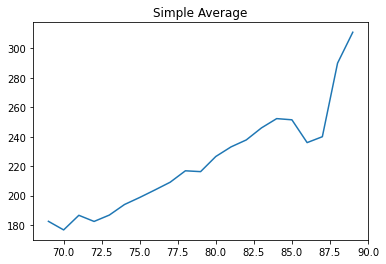

In [693]:
plt.plot(h_range, avg_weight.values())
plt.title('Simple Average')
plt.show()

In [694]:
x = np.array(df['player_height_inches']).reshape((-1,1))
y = df['player_weight']

In [695]:
# Simple linear model of weight as a function of height
model = LinearRegression().fit(x, y)

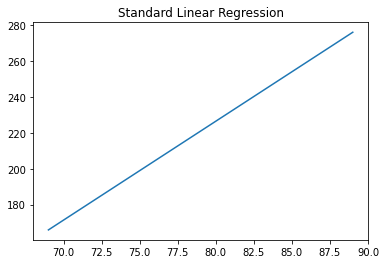

In [696]:
l_preds = model.predict(h_range)
plt.plot(h_range, l_preds)
plt.title('Standard Linear Regression')
plt.show()

In [697]:
transformer = PolynomialFeatures(degree=2)
X = transformer.fit_transform(x)

In [698]:
# Polynomial model
model = LinearRegression().fit(X, y)

In [699]:
X_ = transformer.transform(h_range.reshape((-1,1)))
p_preds = model.predict(X_)

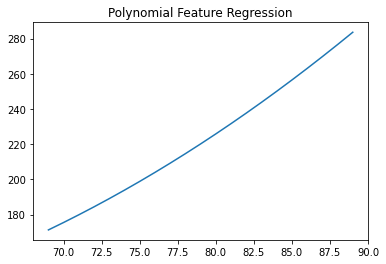

In [700]:
plt.plot(h_range, p_preds)
plt.title('Polynomial Feature Regression')
plt.show()

In [701]:
# Creating dictionary from polynomial model
reg = { int(h_range[i]): preds[i] for i in range(len(h_range)) }

In [702]:
# Create a predicted weight
df['predicted_weight'] = df['player_height_inches'].map(lambda x: reg[x])

# Add column for difference between "adjusted average"
df['TAAR'] = df['player_weight'] - df['predicted_weight']

In [703]:
df.head()

,player_name,team_abbreviation,player_height_inches,player_weight,avg_weight,TAR,STAR,predicted_weight,TAAR
0,Aaron Gordon,ORL,80,235,226.568966,8.431034,0.5741,225.834053,9.165947
1,Aaron Holiday,IND,72,185,182.428571,2.571429,0.1751,184.390905,0.609095
2,Abdel Nader,OKC,77,225,209.079365,15.920635,1.0840,209.198190,15.801810
3,Adam Mokoka,CHI,77,190,209.079365,-19.079365,-1.2991,209.198190,-19.198190
4,Admiral Schofield,WAS,77,241,209.079365,31.920635,2.1735,209.198190,31.801810


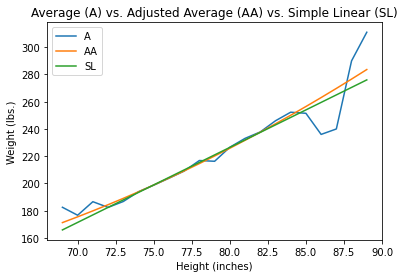

In [704]:
plt.plot(h_range, avg_weight.values(), h_range, p_preds, h_range, l_preds)
plt.title('Average (A) vs. Adjusted Average (AA) vs. Simple Linear (SL)')
plt.xlabel('Height (inches)')
plt.ylabel('Weight (lbs.)')

labels = ['A', 'AA', 'SL']
plt.legend(labels)

plt.show()

#### Note:
Small sample size under/over penalized players at certain heights

In [705]:
df.loc[df['player_height_inches'] == 85]

,player_name,team_abbreviation,player_height_inches,player_weight,avg_weight,TAR,STAR,predicted_weight,TAAR
213,Jakob Poeltl,SAS,85,245,251.5,-6.5,-0.4426,256.479642,-11.479642
436,Rudy Gobert,UTA,85,258,251.5,6.5,0.4426,256.479642,1.520358


In [706]:
df.loc[df['player_height_inches'] == 86]

,player_name,team_abbreviation,player_height_inches,player_weight,avg_weight,TAR,STAR,predicted_weight,TAAR
26,Anzejs Pasecniks,WAS,86,229,236.0,-7.0,-0.4766,263.046632,-34.046632
40,Bol Bol,DEN,86,220,236.0,-16.0,-1.0894,263.046632,-43.046632
337,Luke Kornet,CHI,86,250,236.0,14.0,0.9533,263.046632,-13.046632
382,Moses Brown,POR,86,245,236.0,9.0,0.6128,263.046632,-18.046632


## Percent Thickness Above Adjusted Replacement (PTAAR) <a class="anchor" id="ptaar"></a>
**Issue:** 10 lbs. extra on a 6' player is not equivalent to 10 lbs. extra on a 7' player.

**Solution:** TAAR / predicted player weight

In [707]:
df['PTAAR'] = df['TAAR'] / df['predicted_weight']

In [708]:
df.sort_values('TAR', ascending=False).head()

,player_name,team_abbreviation,player_height_inches,player_weight,avg_weight,TAR,STAR,predicted_weight,TAAR,PTAAR
527,Zion Williamson,NOP,78,284,216.839286,67.160714,4.5729,214.597520,69.402480,0.323408
17,Andre Drummond,CLE,82,279,237.804878,41.195122,2.8049,237.654415,41.345585,0.173974
226,Jarrell Brantley,UTA,77,250,209.079365,40.920635,2.7863,209.198190,40.801810,0.195039
414,Paul Millsap,DEN,79,257,216.274510,40.725490,2.7730,220.142808,36.857192,0.167424
159,Eric Paschall,GSW,78,255,216.839286,38.160714,2.5983,214.597520,40.402480,0.188271


In [709]:
df.sort_values('TAAR', ascending=False).head()

,player_name,team_abbreviation,player_height_inches,player_weight,avg_weight,TAR,STAR,predicted_weight,TAAR,PTAAR
527,Zion Williamson,NOP,78,284,216.839286,67.160714,4.5729,214.597520,69.402480,0.323408
17,Andre Drummond,CLE,82,279,237.804878,41.195122,2.8049,237.654415,41.345585,0.173974
226,Jarrell Brantley,UTA,77,250,209.079365,40.920635,2.7863,209.198190,40.801810,0.195039
159,Eric Paschall,GSW,78,255,216.839286,38.160714,2.5983,214.597520,40.402480,0.188271
284,Jusuf Nurkic,POR,84,290,252.304348,37.695652,2.5667,250.058609,39.941391,0.159728


In [710]:
df.sort_values('PTAAR', ascending=False).head()

,player_name,team_abbreviation,player_height_inches,player_weight,avg_weight,TAR,STAR,predicted_weight,TAAR,PTAAR
527,Zion Williamson,NOP,78,284,216.839286,67.160714,4.5729,214.597520,69.402480,0.323408
226,Jarrell Brantley,UTA,77,250,209.079365,40.920635,2.7863,209.198190,40.801810,0.195039
159,Eric Paschall,GSW,78,255,216.839286,38.160714,2.5983,214.597520,40.402480,0.188271
120,Deonte Burton,OKC,76,240,203.833333,36.166667,2.4626,203.944818,36.055182,0.176789
17,Andre Drummond,CLE,82,279,237.804878,41.195122,2.8049,237.654415,41.345585,0.173974


## Standardized Thickness Above Adjusted Replacement (STAAR) <a class="anchor" id="staar"></a>
**Issue:** Values are not standardized.

**Solution:** Standardize values for PTAAR.

In [711]:
X = np.array(df['PTAAR']).reshape((-1,1))
scaler = StandardScaler()
staar = scaler.fit_transform(X)

In [712]:
df['STAAR'] = staar

In [713]:
df.sort_values('STAAR', ascending=False).head(10)

,player_name,team_abbreviation,player_height_inches,player_weight,avg_weight,TAR,STAR,predicted_weight,TAAR,PTAAR,STAAR
527,Zion Williamson,NOP,78,284,216.839286,67.160714,4.5729,214.597520,69.402480,0.323408,4.721591
226,Jarrell Brantley,UTA,77,250,209.079365,40.920635,2.7863,209.198190,40.801810,0.195039,2.847475
159,Eric Paschall,GSW,78,255,216.839286,38.160714,2.5983,214.597520,40.402480,0.188271,2.748664
120,Deonte Burton,OKC,76,240,203.833333,36.166667,2.4626,203.944818,36.055182,0.176789,2.581033
17,Andre Drummond,CLE,82,279,237.804878,41.195122,2.8049,237.654415,41.345585,0.173974,2.539930
404,P.J. Tucker,HOU,77,245,209.079365,35.920635,2.4458,209.198190,35.801810,0.171138,2.498536
414,Paul Millsap,DEN,79,257,216.274510,40.725490,2.7730,220.142808,36.857192,0.167424,2.444310
512,Wendell Carter Jr.,CHI,81,270,233.093023,36.906977,2.5130,231.671255,38.328745,0.165445,2.415411
284,Jusuf Nurkic,POR,84,290,252.304348,37.695652,2.5667,250.058609,39.941391,0.159728,2.331954
4,Admiral Schofield,WAS,77,241,209.079365,31.920635,2.1735,209.198190,31.801810,0.152018,2.219384


## Modifications on Metrics <a class="anchor" id="mods"></a>
**Issues:**
- Sample size at certain heights skewing data.  As seen above, the average weights at the extreme heights created uneven "replacement" weights.

**Solutions:**
- Remove extreme heights and re-fit adjusted average weights.

In [714]:
df['player_height_inches'].value_counts()

77    63
80    58
78    56
79    51
75    47
81    43
76    42
82    41
83    29
73    27
84    23
74    16
72    14
71     5
86     4
70     3
69     2
85     2
88     1
87     1
89     1
Name: player_height_inches, dtype: int64

In [715]:
# Remove extremes of heights
cond1 = (df['player_height_inches'] > 71)
cond2 = (df['player_height_inches'] < 85)
new_df = df.loc[cond1 & cond2]
new_x = np.array(new_df['player_height_inches']).reshape((-1,1))
new_y = new_df['player_weight']
new_range = np.arange(new_x.min(), new_x.max() + 1).reshape((-1,1))

# Create polynomial features
transformer = PolynomialFeatures(degree=2)
X = transformer.fit_transform(new_x)

# Linear model
model = LinearRegression().fit(X, new_y)
X_ = transformer.transform(h_range.reshape((-1,1)))
new_preds = model.predict(X_)

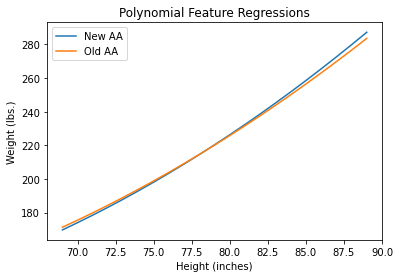

In [716]:
plt.plot(h_range, new_preds, h_range, p_preds)
plt.title('Polynomial Feature Regressions')
plt.xlabel('Height (inches)')
plt.ylabel('Weight (lbs.)')

labels = ['New AA', 'Old AA']
plt.legend(labels)
plt.show()

In [717]:
new_pw = { int(h_range[i]): new_preds[i] for i in range(len(h_range)) }

In [718]:
df['new_pw'] = df['player_height_inches'].map(new_pw)

In [719]:
# Add new STAAR
new_ptaar = np.array((df['player_weight'] - df['new_pw']) / df['new_pw'])
scaler = StandardScaler()
new_staar = scaler.fit_transform(new_ptaar.reshape((-1,1)))
df['new_STAAR'] = np.round(new_staar, 4)

### Comparison to STAR <a class="anchor" id="comp"></a>

In [723]:
df['diff'] = df['new_STAAR'] - df['STAR']

In [726]:
df[['player_name', 'STAR', 'new_STAAR', 'diff']].sort_values('diff', ascending=False).head(10)

,player_name,STAR,new_STAAR,diff
464,Tacko Fall,0.0000,1.2073,1.2073
197,Isaiah Thomas,0.1702,1.3198,1.1496
73,Chris Clemons,-0.1702,0.8900,1.0602
63,Carsen Edwards,0.9124,1.7591,0.8467
165,Frank Mason,0.2315,0.9419,0.7104
262,Jordan McLaughlin,-0.1089,0.5333,0.6422
87,D.J. Augustin,-0.2451,0.3699,0.6150
36,Boban Marjanovic,0.0000,0.5318,0.5318
72,Chris Chiozza,-0.7898,-0.2839,0.5059
479,Thon Maker,-2.1315,-1.7801,0.3514


In [727]:
df[['player_name', 'STAR', 'new_STAAR', 'diff']].sort_values('diff', ascending=True).head(10)

,player_name,STAR,new_STAAR,diff
337,Luke Kornet,0.9533,-0.8481,-1.8014
311,Kristaps Porzingis,0.0000,-1.7412,-1.7412
382,Moses Brown,0.6128,-1.1229,-1.7357
26,Anzejs Pasecniks,-0.4766,-2.0020,-1.5254
40,Bol Bol,-1.0894,-2.4966,-1.4072
436,Rudy Gobert,0.4426,-0.0281,-0.4707
284,Jusuf Nurkic,2.5667,2.2178,-0.3489
268,Josh Magette,-1.8208,-2.1690,-0.3482
414,Paul Millsap,2.7730,2.4303,-0.3427
17,Andre Drummond,2.8049,2.4651,-0.3398


In [729]:
with open('thick_df.p', 'wb') as f:
    pickle.dump(df, f)

In [733]:
# STAAR Top 10
df.sort_values('new_STAAR', ascending=False)[['player_name', 'new_STAAR']].head(10)

,player_name,new_STAAR
527,Zion Williamson,4.7261
226,Jarrell Brantley,2.8728
159,Eric Paschall,2.7542
120,Deonte Burton,2.6254
404,P.J. Tucker,2.5237
17,Andre Drummond,2.4651
414,Paul Millsap,2.4303
512,Wendell Carter Jr.,2.3615
4,Admiral Schofield,2.2443
284,Jusuf Nurkic,2.2178


In [734]:
# STAAR Bottom 10
df.sort_values('new_STAAR', ascending=True)[['player_name', 'new_STAAR']].head(10)

,player_name,new_STAAR
194,Isaac Bonga,-2.9816
82,Corey Brewer,-2.7853
410,Patrick McCaw,-2.6015
40,Bol Bol,-2.4966
309,Kostas Antetokounmpo,-2.3627
277,Justin Holiday,-2.3456
268,Josh Magette,-2.1690
263,Jordan McRae,-2.0852
467,Tariq Owens,-2.0572
216,Jalen McDaniels,-2.0572


In [736]:
df.sort_values('STAR', ascending=False)[['player_name', 'STAR']].head(10)

,player_name,STAR
527,Zion Williamson,4.5729
17,Andre Drummond,2.8049
226,Jarrell Brantley,2.7863
414,Paul Millsap,2.7730
159,Eric Paschall,2.5983
284,Jusuf Nurkic,2.5667
512,Wendell Carter Jr.,2.5130
120,Deonte Burton,2.4626
404,P.J. Tucker,2.4458
211,Jahlil Okafor,2.1921


In [735]:
df.sort_values('STAR', ascending=True)[['player_name', 'STAR']].head(10)

,player_name,STAR
194,Isaac Bonga,-3.1708
82,Corey Brewer,-3.0704
309,Kostas Antetokounmpo,-2.5741
277,Justin Holiday,-2.5084
410,Patrick McCaw,-2.4018
71,Chris Boucher,-2.2533
216,Jalen McDaniels,-2.2337
467,Tariq Owens,-2.2337
479,Thon Maker,-2.1315
392,Nicolas Claxton,-2.1108
